In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata =  sc.datasets.pbmc3k_processed()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
import torch

In [5]:
import sys
sys.path.append("../src/")

In [6]:
%load_ext autoreload
%autoreload 2

import scdeepaa

In [7]:
import torch
torch.cuda.is_available()

True

In [8]:
input_matrix, norm_factor, distribution_type = scdeepaa.get_input_params_adata(adata)

In [20]:
res = scdeepaa.fit_deepAA(
    [adata.X],
    [np.ones(adata.X.shape[0])],
    ["G"],
    hidden_dims_dec_common = [256,256],
    hidden_dims_dec_last = [512],
    hidden_dims_enc_ind = [512],
    hidden_dims_enc_common = [256,256],
    hidden_dims_enc_pre_Z = [128, 64],
    lr = 0.01,
    gamma_lr = 0.01,
    steps = 1000,
    narchetypes = 5,
    fix_Z = False)


ELBO: 364647750.55143  : 100%|██████████| 1000/1000 [00:19<00:00, 51.65it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


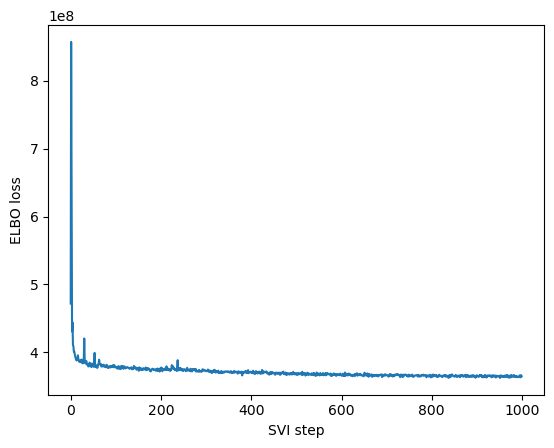

In [21]:
scdeepaa.plot_ELBO(res)

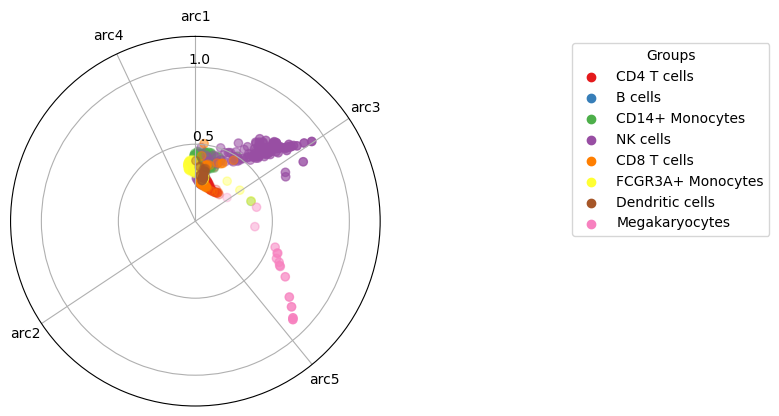

In [22]:
scdeepaa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

In [23]:
col_names = [ "arc" + str(i+1) for i in range(res["inferred_quantities"]["A"].shape[1])]

Z_arc = pd.DataFrame(res["inferred_quantities"]["A"], columns= col_names, index = adata.obs_names )

In [24]:
adata =  sc.datasets.pbmc3k_processed()

In [25]:
adata.obs = pd.concat([adata.obs, Z_arc], axis=1)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


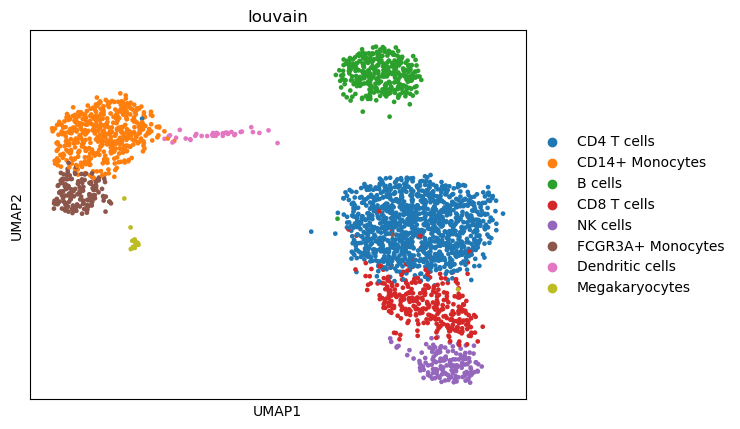

In [26]:
sc.pl.umap(adata, color="louvain")


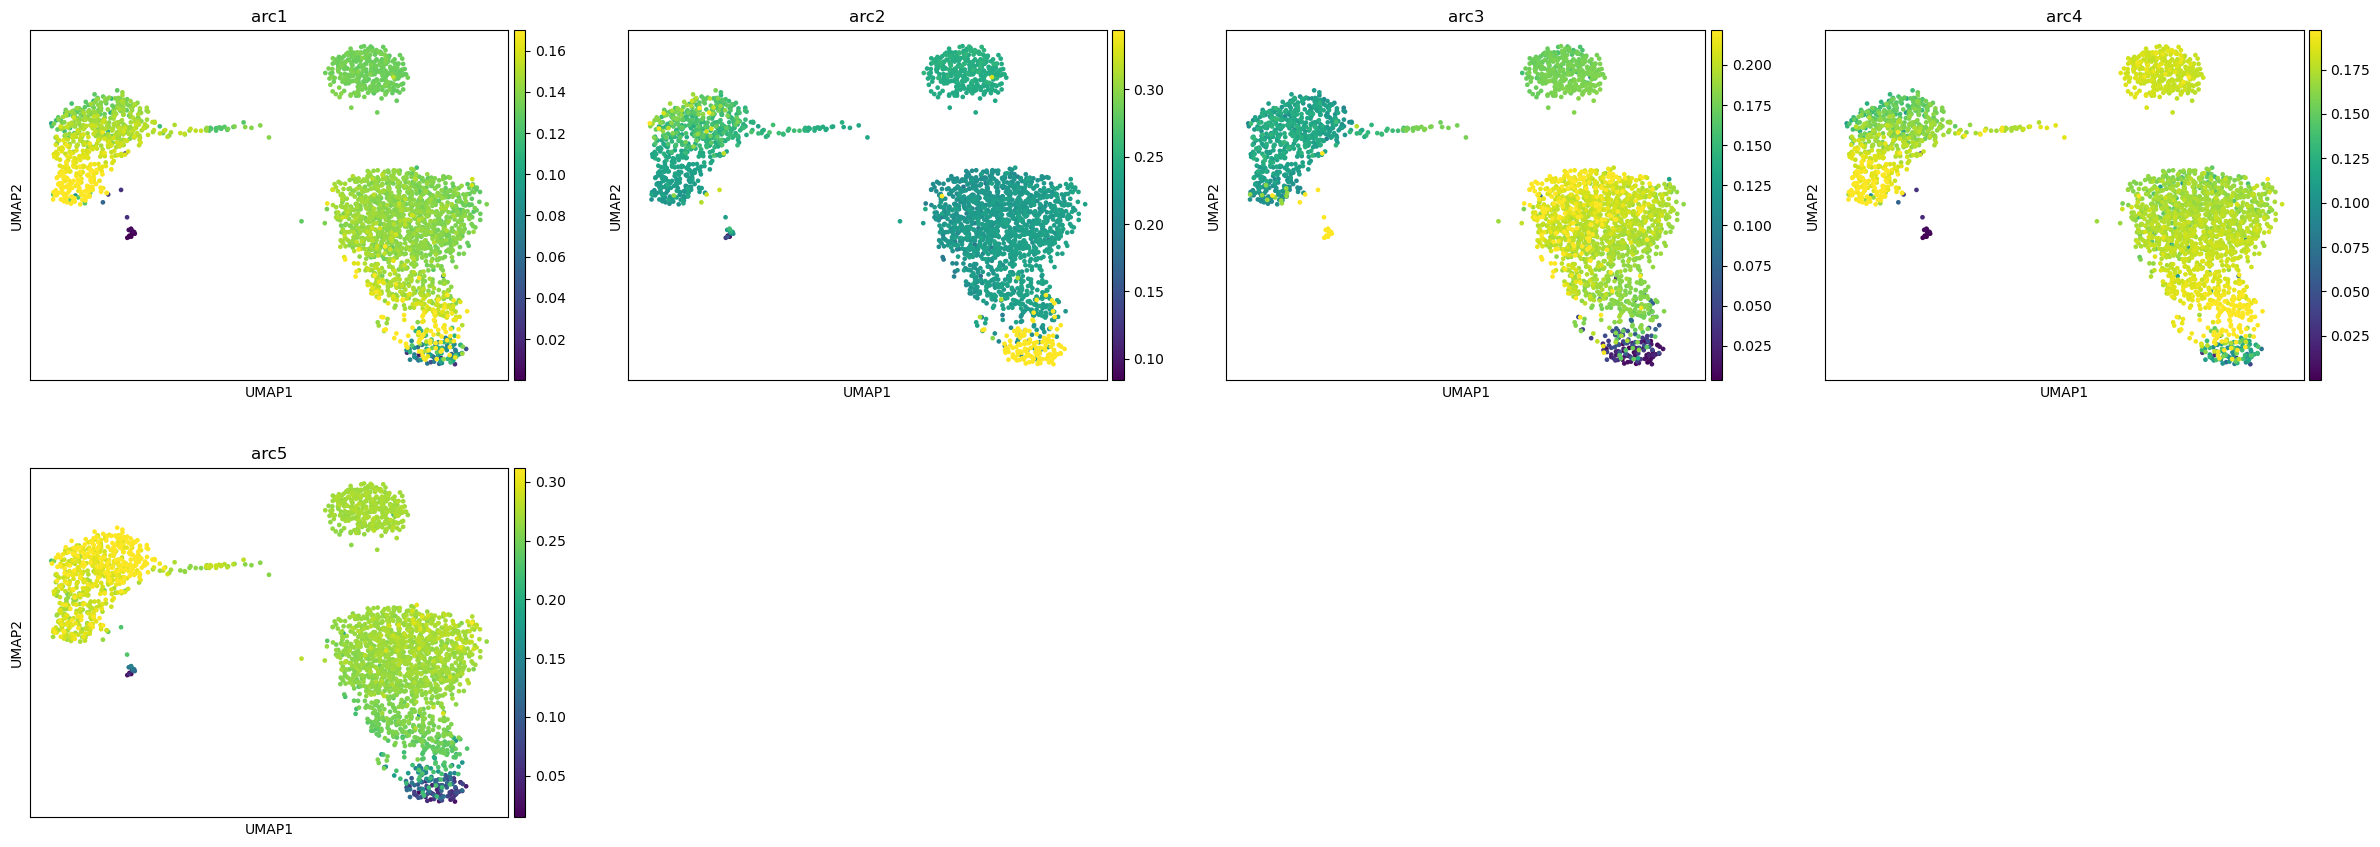

In [27]:
sc.pl.umap(adata, color=col_names, vmax="p95")


In [28]:
adata.obsm["X_aa"] = res["inferred_quantities"]["A"] @ res["inferred_quantities"]["archetypes_inferred"]

In [29]:
sc.pp.neighbors(adata, use_rep = "X_aa",n_neighbors=10)


<Axes: >

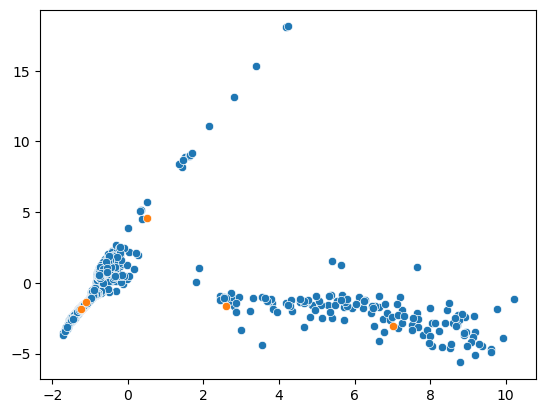

In [30]:
import seaborn as sns

sns.scatterplot(x = res["inferred_quantities"]["Z"][:,0], y = res["inferred_quantities"]["Z"][:,1])

sns.scatterplot(x = res["inferred_quantities"]["archetypes_inferred"][:,0], y = res["inferred_quantities"]["archetypes_inferred"][:,1])

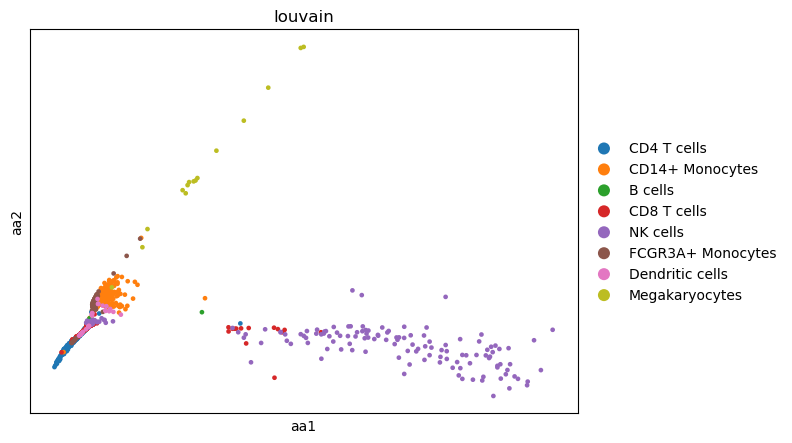

In [31]:
sc.pl.scatter(adata, basis= "aa", color="louvain")

In [32]:
sc.tl.umap(adata)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


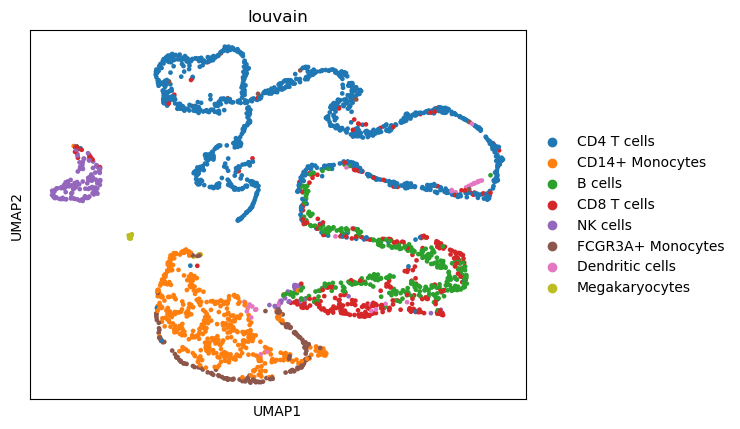

In [33]:
sc.pl.umap(adata, color="louvain")


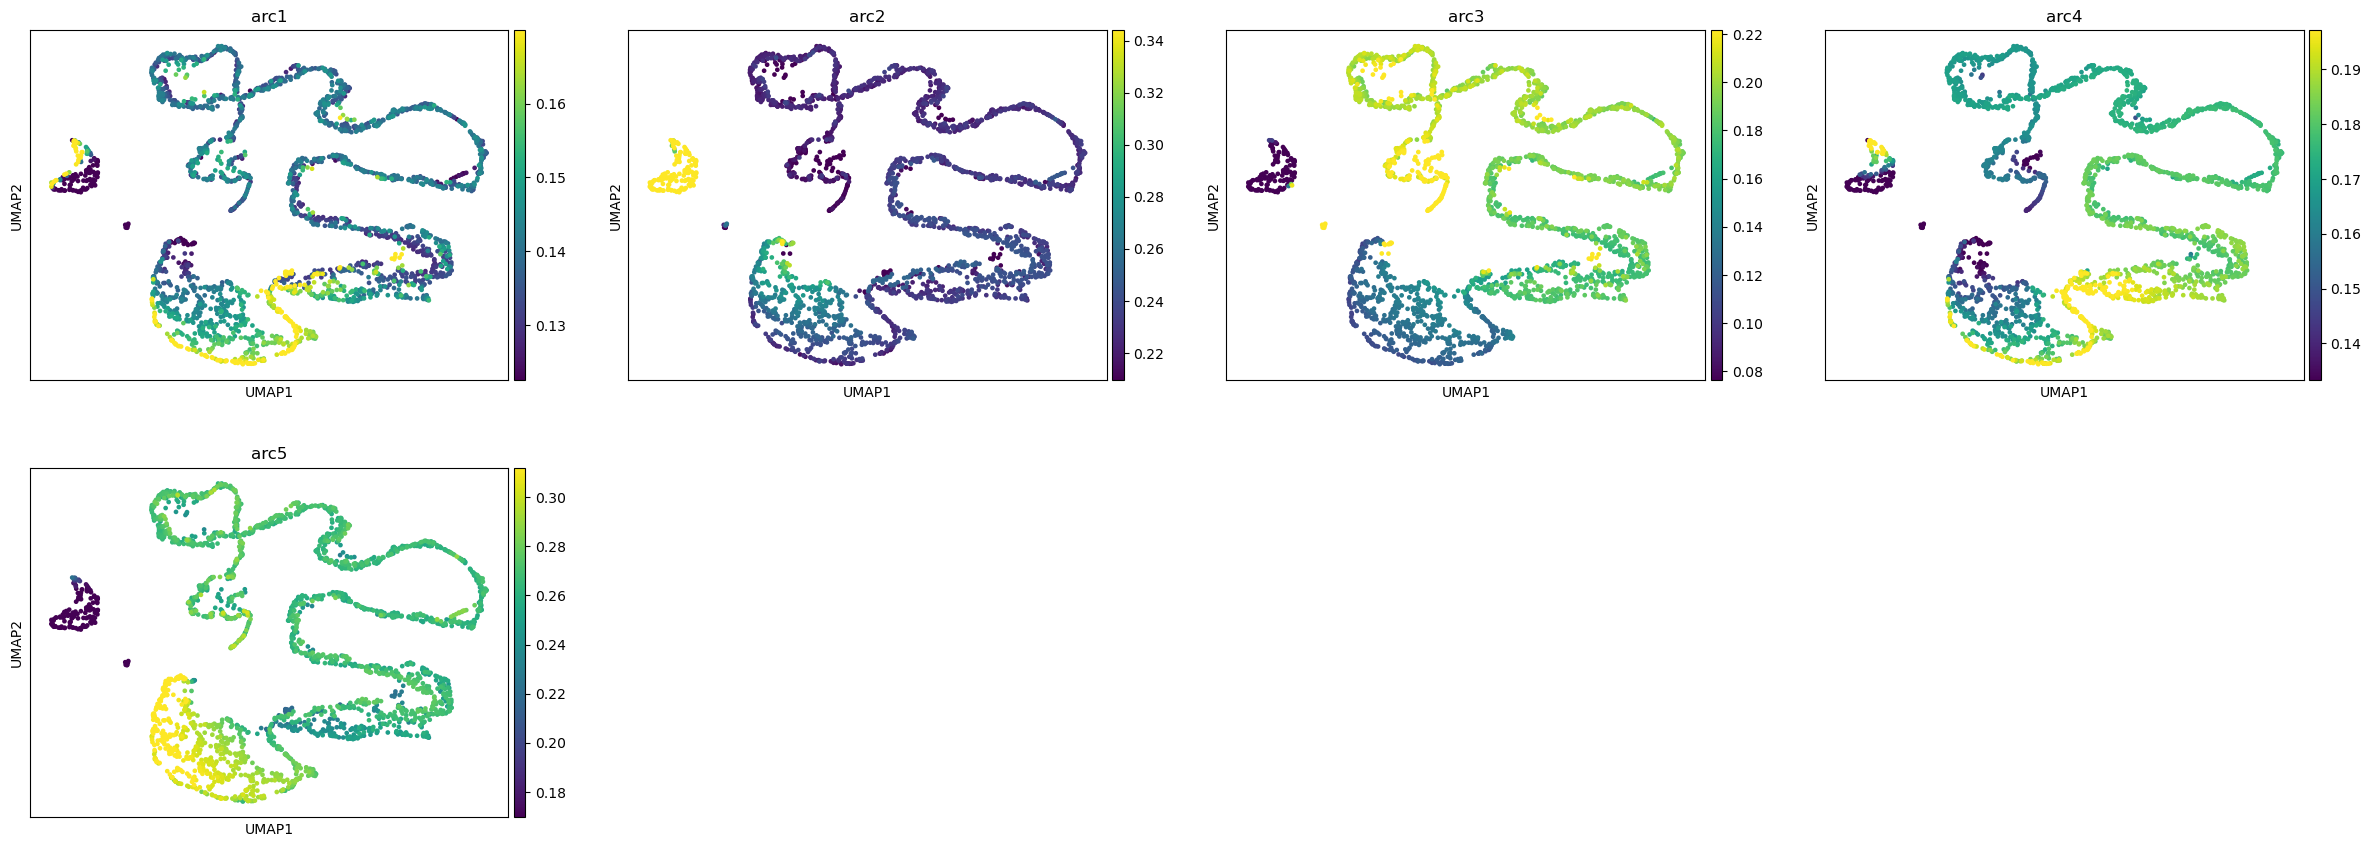

In [34]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [35]:
side_mat = pd.get_dummies(adata.obs["louvain"], prefix='louvain') 
side_mat = side_mat.to_numpy().astype(float)

In [36]:
side_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [103]:
res = scdeepaa.fit_deepAA(
    [adata.X],
    [np.ones(adata.X.shape[0])],
    ["G"],
    side_matrices = [side_mat], 
    input_types_side = ["C"],
    loss_weights_reconstruction = [1e-6],
    loss_weights_side = [1],
    lr = 0.001,
    gamma_lr = 0.01,
    steps = 600,
    narchetypes = 8,
    fix_Z = False
    )

ELBO: -43296.51067  : 100%|██████████| 600/600 [00:18<00:00, 32.19it/s]


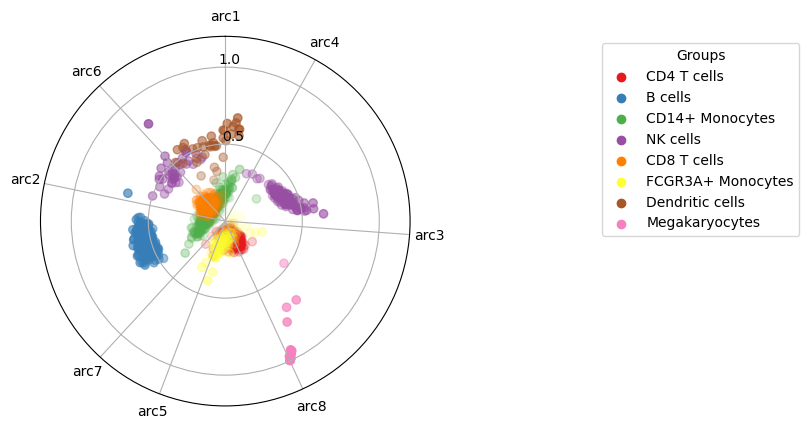

In [104]:
scdeepaa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

In [89]:
adata =  sc.datasets.pbmc3k_processed()

In [90]:
col_names = [ "arc" + str(i+1) for i in np.arange(res["hyperparametes"]["narchetypes"])]

In [91]:
Z_arc = pd.DataFrame(res["inferred_quantities"]["A"], columns= col_names, index = adata.obs_names )

In [92]:
adata.obs = pd.concat([adata.obs, Z_arc], axis=1)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


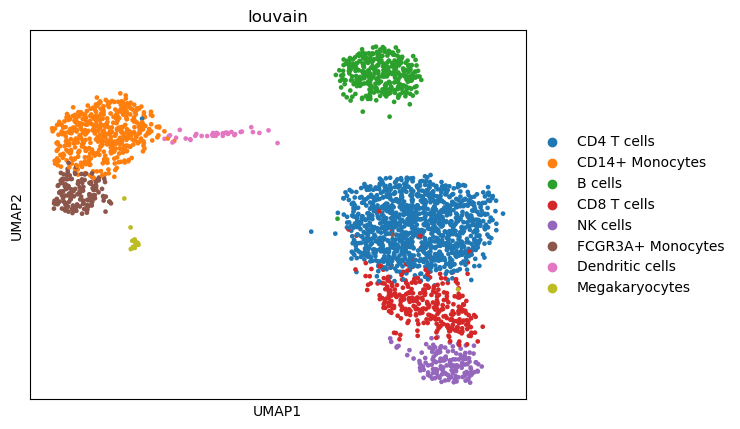

In [93]:
sc.pl.umap(adata, color="louvain")


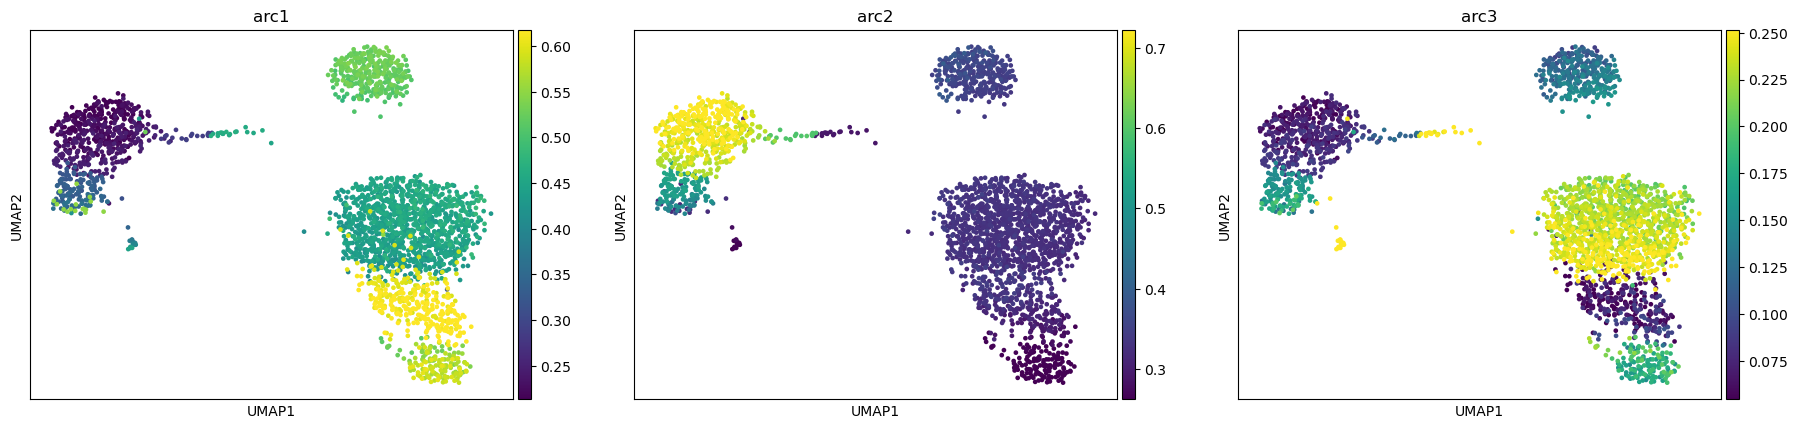

In [94]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [95]:
res["inferred_quantities"]["input_loss"]

array(-4271.92169374)

In [96]:
res["inferred_quantities"]["side_loss"]

array(-110424.37, dtype=float32)

In [97]:
adata.obsm["X_aa"] = res["inferred_quantities"]["A"] @ res["inferred_quantities"]["archetypes_inferred"]

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


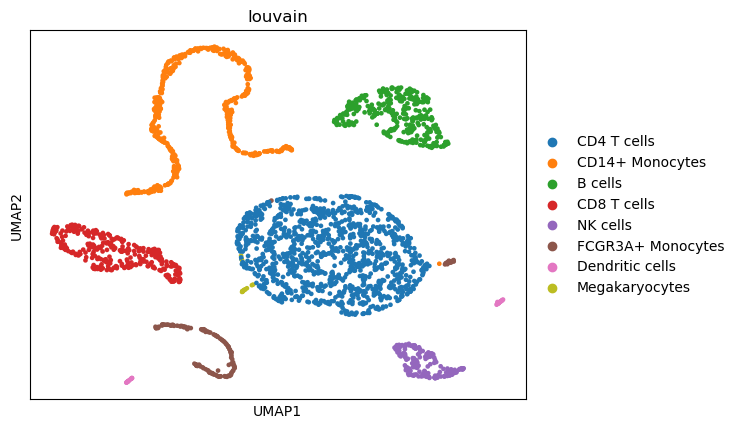

In [98]:
sc.pp.neighbors(adata, use_rep = "X_aa")
sc.tl.paga(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="louvain")


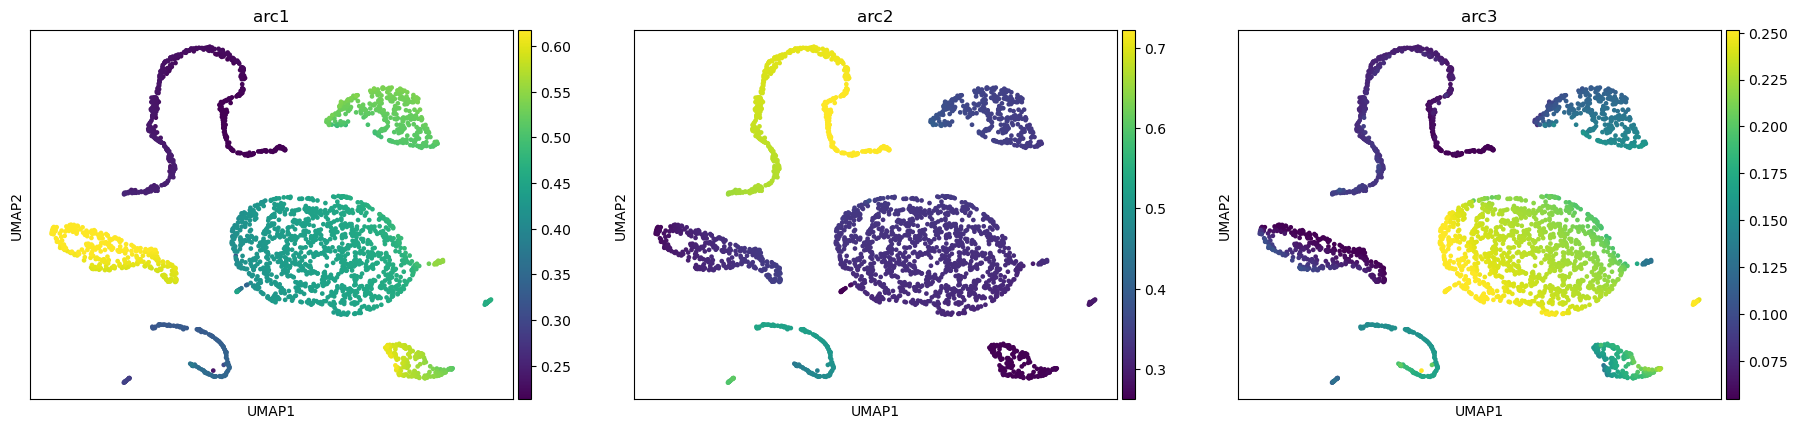

In [99]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [72]:
sc.tl.leiden(adata, resolution=0.05)


/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


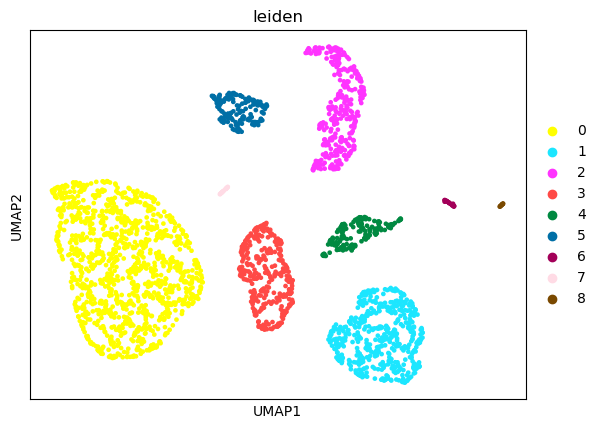

In [73]:
sc.pl.umap(adata, color="leiden")


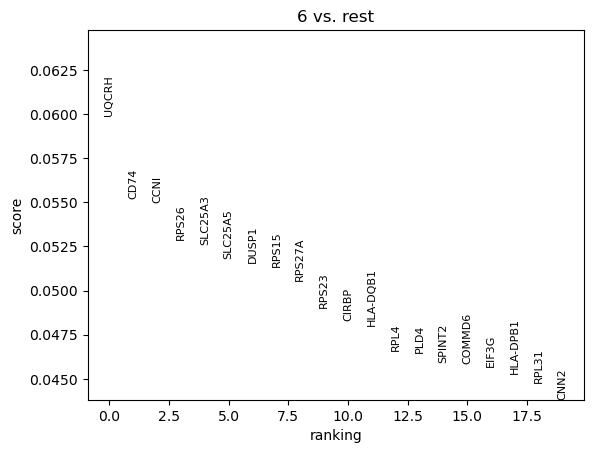

In [83]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', groups=[6,7])
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

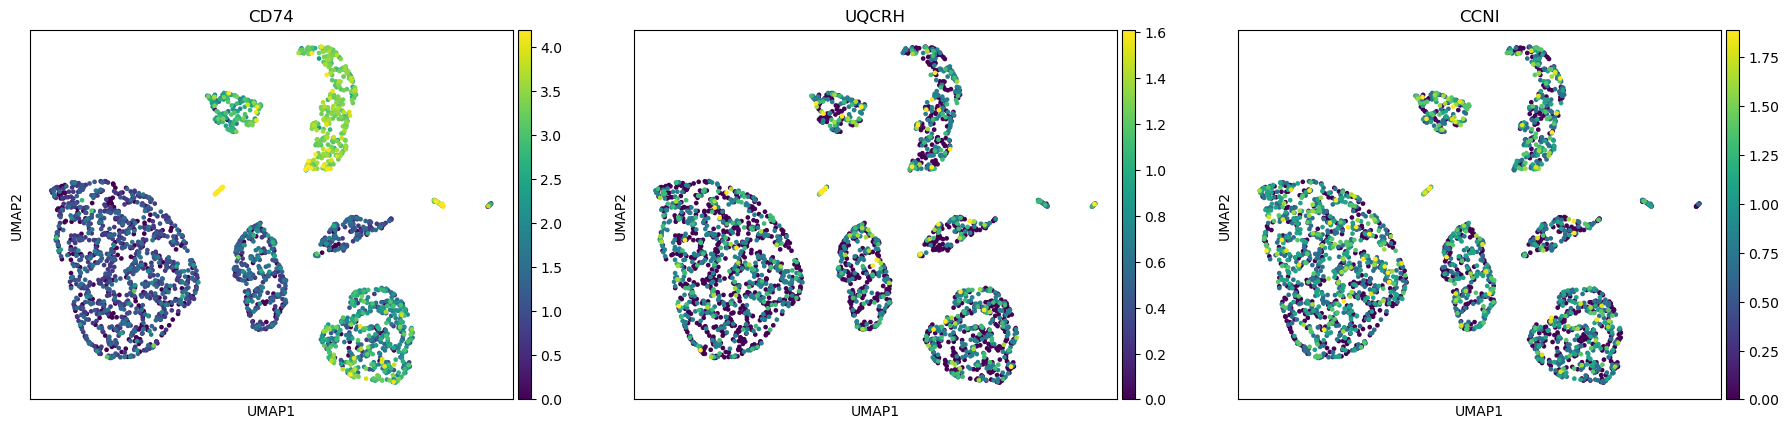

In [85]:
sc.pl.umap(adata, color=["CD74", "UQCRH", "CCNI"], vmax = "p99")
